In [1]:
import os
import matplotlib.pyplot as plt
import h5py
import phase_contrast as pc
from pathlib import Path
import numpy as np
from PIL import Image
from file_paths import get_path

In [2]:
from scipy.interpolate import interp1d
from helper import crop

from scipy.ndimage import zoom
from scipy.ndimage.morphology import binary_closing
from skimage.morphology import disk
from skimage import measure
import scipy.ndimage as ndimage

In [3]:
SCRIPT_PATH = os.getcwd()
PHANTOM_DB_FOLDER_NAME = 'database'
TXT_FOULDER_NAME = 'txt_files'
FILE_ID = '123499'
TXT_FILE_NAME = f'diamond {FILE_ID}.txt'

In [4]:
def get_img(file_name):
    file_path = os.path.join(SCRIPT_PATH, PHANTOM_DB_FOLDER_NAME, file_name)

    with h5py.File(file_path, 'r') as hdf:
        dataset = hdf.get(name = file_name)
        dataset = dataset[()]
    return dataset

In [5]:
def get_2d_slice(num):
    data_folder = get_path(FILE_ID)

    file_names = Path(data_folder).glob('*.tiff')
    file_names = list(file_names)
    img2d_gray = img2d = np.array(Image.open(file_names[num]))

    return img2d_gray

In [6]:
def write_dict_to_file(dict):
    for key, value in dict.items():
        write_item_to_file(key, value)


def write_item_to_file(key, value):
    db_folder = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME)
    if not os.path.isdir(db_folder):
        os.mkdir(db_folder)

    file_path = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME, TXT_FILE_NAME)
    file_txt = open(file_path,"a")
    file_txt.write(f"{key} {value} \n")
    file_txt.close()


In [31]:
k_dictionary ={}

In [53]:
a = np.asarray([-3, -4, -1,2,3,2,1,5, -5,1])
np.argmax(np.abs(np.diff(a > 0)))

2

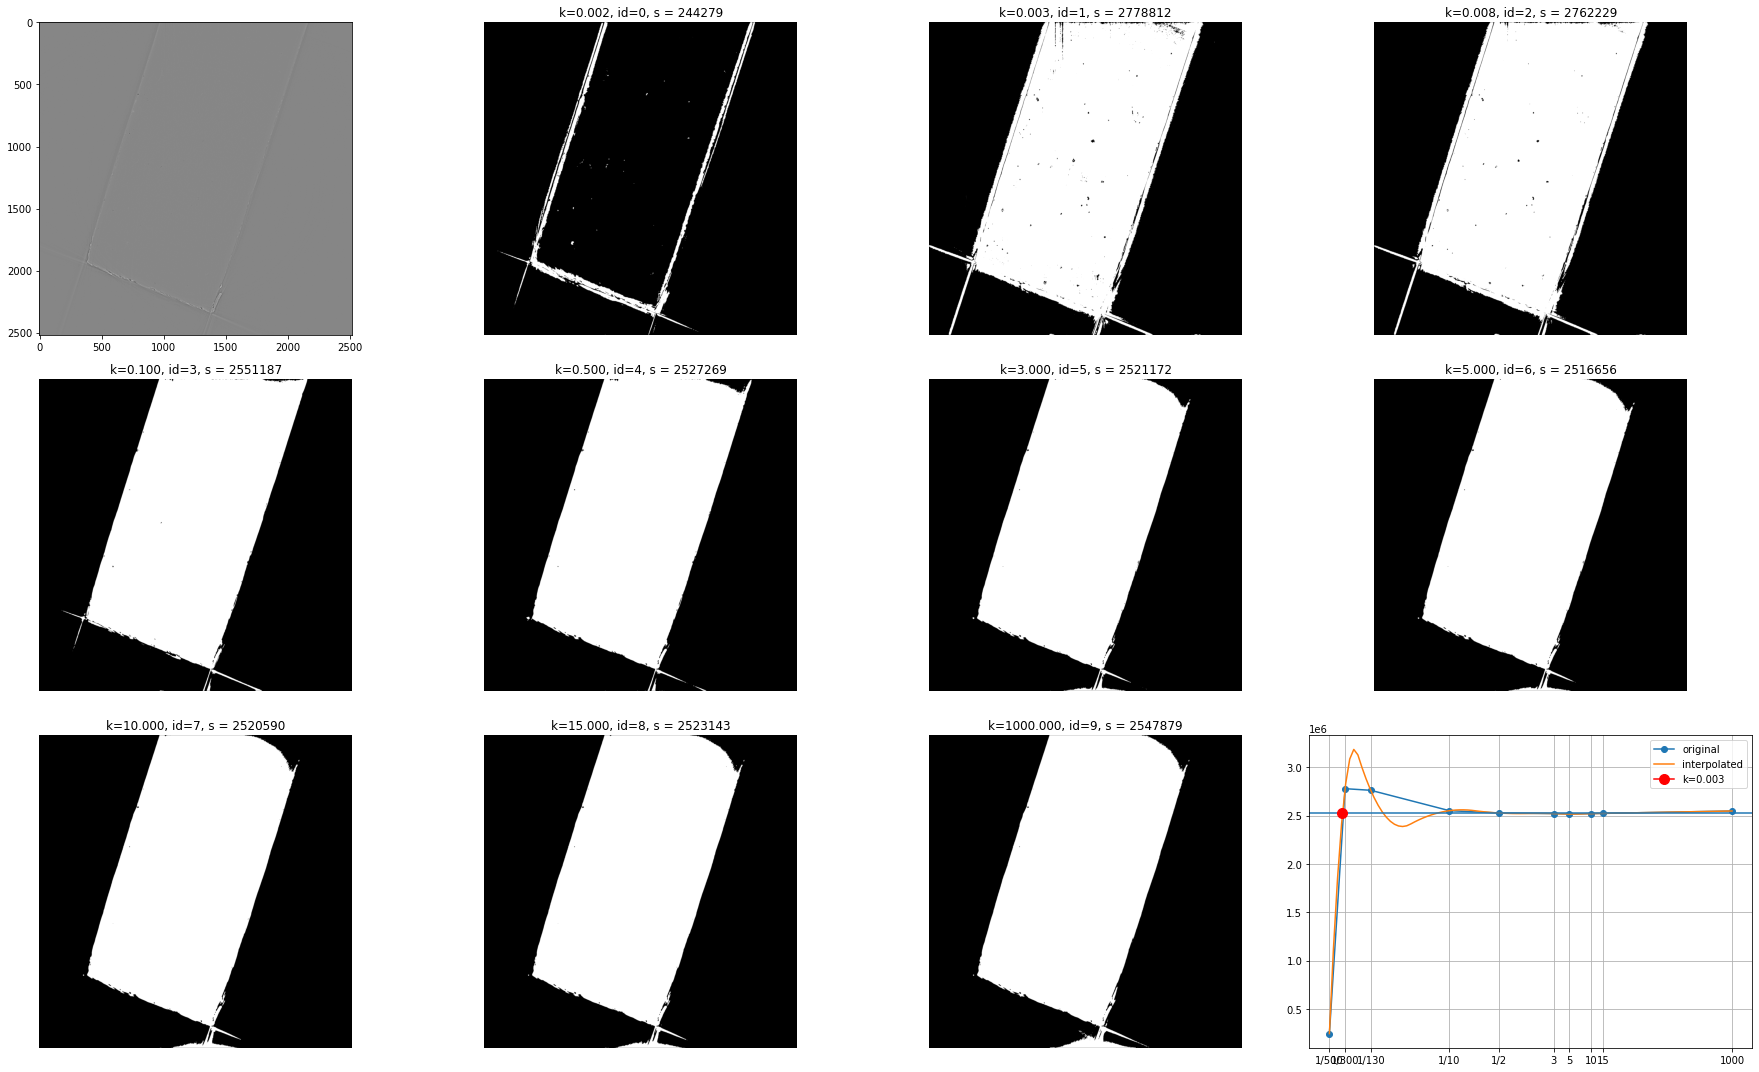

In [57]:
#k_possible_values = [1/10, 1/20, 1/80, 1/100, 1/130, 1/500, 1/300]
k_possible_values = [1/500, 1/300, 1/130, 1/10, 1/2, 3, 5, 10, 15, 1000]
slice_num = 787
k = k_possible_values[0]

img2d_gray = get_2d_slice(slice_num)
fig, axes = plt.subplots(3, 4, figsize=(25,15))

axes = axes.ravel()
axes[0].imshow(img2d_gray, cmap='gray')

squares = []
for i, k in enumerate(k_possible_values):
    bin_img = pc.binarize_slice(img2d_gray, k=k, mu=25e-8)
    square = np.sum(bin_img)
    squares.append(square)
    axes[i+1].imshow(bin_img, cmap='gray')
    axes[i+1].set_title(f"k={k:.3f}, id={i}, s = {square}")
    axes[i+1].axis("off")

x_log = np.log(k_possible_values)

f2 = interp1d(x_log, squares, kind='quadratic')
axes[-1].plot(x_log, squares, '-o', label='original')
x_new = np.linspace(np.min(x_log), np.max(x_log), num=100, endpoint=True)
y_new = f2(x_new)
axes[-1].plot(x_new, y_new, '-', label='interpolated')
y_horizental_line = np.percentile(y_new, 55)

indx = np.argmax(np.abs(np.diff((y_new - y_horizental_line) > 0)))
x_intersection_point = x_new[indx]
k_calculated = np.exp(x_intersection_point)
axes[-1].axhline(y_horizental_line)
axes[-1].plot([x_intersection_point], [y_horizental_line], marker='o', markersize=10, color="red", label=f'k={k_calculated:.3f}')
x_ticks = ['1/500', '1/300', '1/130', '1/10', '1/2', '3', '5', '10', '15', '1000']
plt.xticks(np.log(k_possible_values), x_ticks)
axes[-1].grid()
axes[-1].legend()

plt.tight_layout()

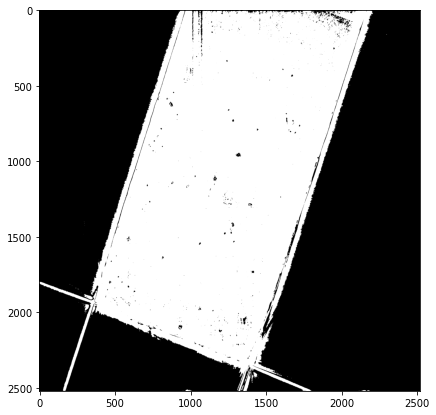

In [58]:

fig, axes = plt.subplots(figsize=(7, 7))
axes.imshow(pc.binarize_slice(img2d_gray, k=k_calculated, mu=25e-8), cmap='gray')


In [98]:
#id = 7
#k_dictionary.update({f"{slice_num}": k_possible_values[id]})

k_dictionary.update({f"{slice_num}": k_calculated})

In [99]:
k_dictionary

{'1700': 0.15874010519681997,
 '1800': 0.7788806357951077,
 '1900': 0.7788806357951077,
 '2000': 3.8216873049467046,
 '2100': 0.7788806357951077}

In [100]:
k_dictionary = sorted(k_dictionary.items(), key=lambda item: item[0])
k_dictionary = dict(k_dictionary)

In [101]:
#k_dictionary = {'750': 500, '780': 0.5, '810': 20, '840': 20, '870': 15}
k_dictionary

{'1700': 0.15874010519681997,
 '1800': 0.7788806357951077,
 '1900': 0.7788806357951077,
 '2000': 3.8216873049467046,
 '2100': 0.7788806357951077}

In [102]:
# backup
write_dict_to_file(k_dictionary)
k_dictionary = {}

# RESULTS

In [7]:
img3d = get_img(f'123499.h5')

1565

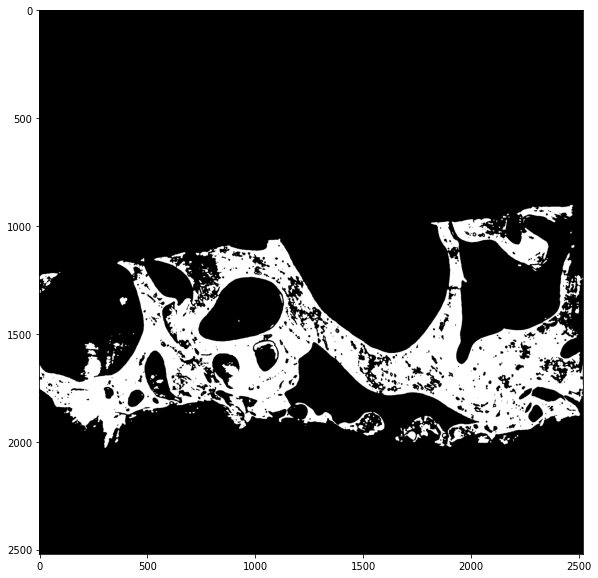

In [8]:
# 787 = good example
num = np.random.randint(0,2120)

fig, axes = plt.subplots(figsize=(10,10))
axes.imshow(img3d[num], cmap='gray')
num

In [9]:


img2d = img3d[num]
img2d_volume = np.sum(img2d)
img2d_init = np.copy(img2d)
pad_width = 35
disk_radius=35
zoom_scale=0.1
section_shape = img3d.shape[1:]
print('section_shape: ', section_shape)
img2d = zoom(img2d, zoom_scale, order=1)
volume = 0
mask = pc.get_2d_mask(img2d, pad_width = 35, disk_radius=35, zoom_scale=1)
mask = crop(zoom(mask, 1/zoom_scale, order=1), section_shape)

section_shape:  (2520, 2520)


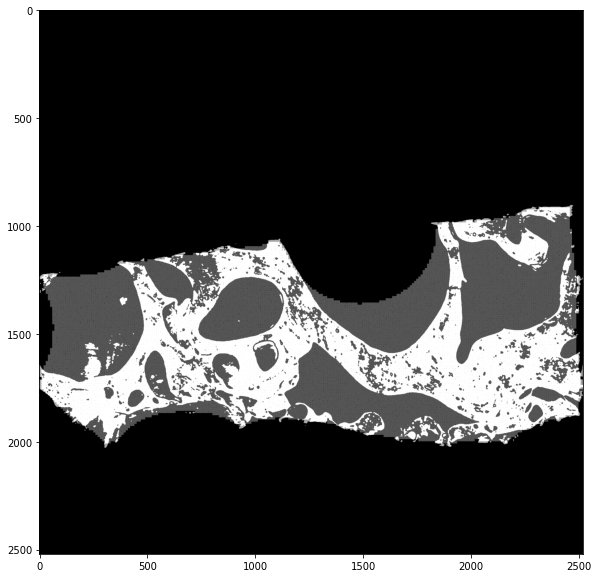

In [10]:
fig, axes = plt.subplots(figsize=(10,10))
axes.imshow(mask+img2d_init*2, cmap='gray')

In [163]:
1 - img2d_volume / np.sum(mask)

-0.028713751311778113

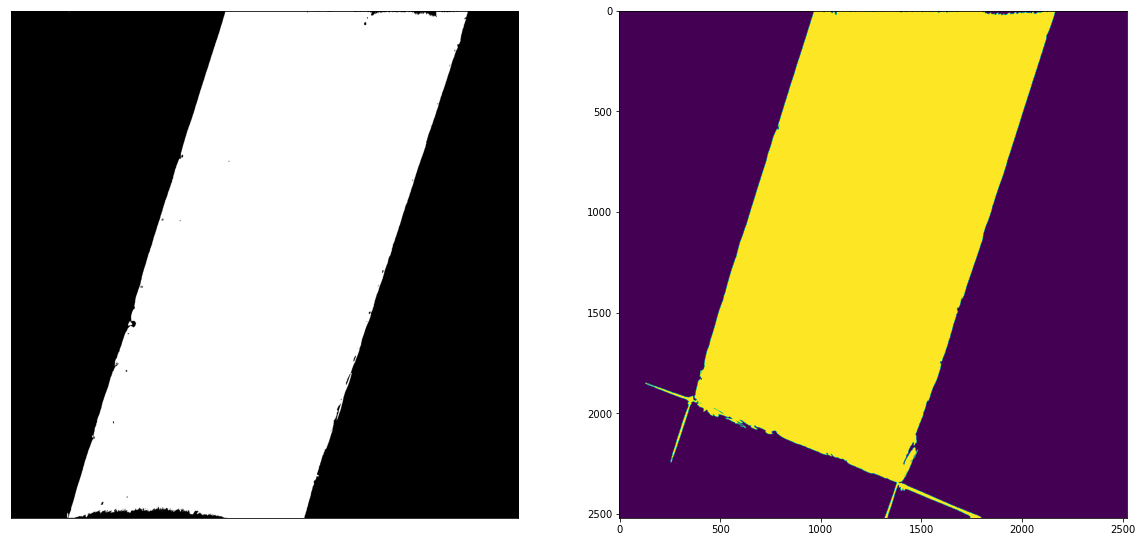

In [165]:


# Find contours at a constant value of 0.8
contours = measure.find_contours(img3d[num], 0.8)

# Display the image and plot all contours found
fig, axes = plt.subplots(1, 2, figsize = (20, 10))

ax = axes[0]
ax.imshow(img3d[num], cmap=plt.cm.gray)

largest_contour = contours[0] 
ax.plot(largest_contour[:, 1], largest_contour[:, 0], linewidth=2, color='red')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

r_mask = np.zeros_like(img3d[num], dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
r_mask = ndimage.morphology.binary_dilation(r_mask)

# # Fill in the hole created by the contour boundary
# r_mask = ndimage.binary_fill_holes(r_mask)

# # Invert the mask since you want pixels outside of the region
# r_mask = ~r_mask
r_mask = r_mask.astype(int)
axes[1].imshow(flood_fill(r_mask,  seed_point=tuple(np.asarray(r_mask.shape) // 2) ,new_value =1))

In [121]:
from skimage.segmentation import flood_fill

In [149]:
r_mask = r_mask.astype(int)
r_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

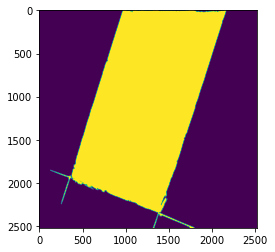

In [151]:
plt.imshow(flood_fill(r_mask,  seed_point=tuple(np.asarray(r_mask.shape) // 2) ,new_value =1))

In [144]:
arr = [[0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0]]
arr = np.asarray(arr)
print(np.asarray(arr.shape)//2)
flood_fill(arr,  seed_point=tuple(np.asarray(arr.shape) // 2), new_value =True)

[3 3]


array([[0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [76]:
contours[0]

array([[0.000e+00, 9.802e+02],
       [8.000e-01, 9.810e+02],
       [8.000e-01, 9.820e+02],
       ...,
       [8.000e-01, 9.690e+02],
       [8.000e-01, 9.700e+02],
       [0.000e+00, 9.708e+02]])

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
img_maski = pc.get_3d_mask(img3d)
num=2020
axes.imshow(img_maski[num]+img3d[num]*2, cmap='gray')
num

2020

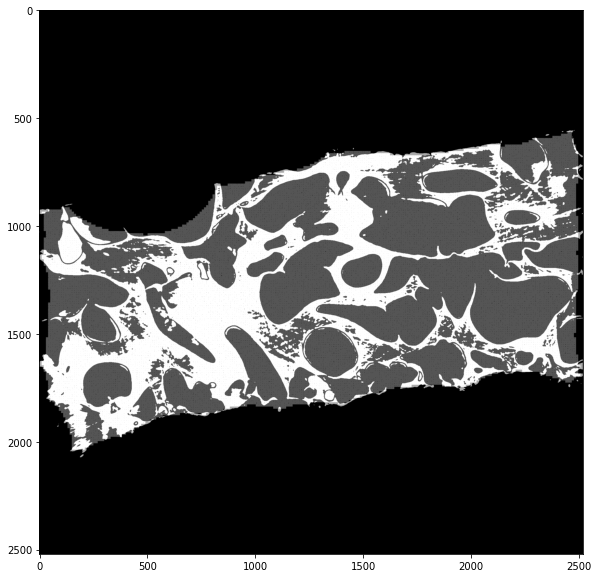

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
num=2020
img_maski = pc.get_2d_mask(img3d[num])
axes.imshow(img_maski+img3d[num]*2, cmap='gray')
num

In [22]:
sample_params = [('123493', False),
                 ('123494', True),
                 ('123495', False),
                 ('123496', True),
                 ('123497', False),
                 ('123498', True),
                 ('123499', True)]

for file_id, mask_needed in sample_params:
    img3d = get_img(f'{file_id}.h5')
    void_volume = np.sum(img3d)
    if mask_needed:
        img3d_mask = np.asarray([pc.get_2d_mask(img2d) for img2d in img3d])
        sample_volume = np.sum(img3d_mask)
    else:
        sample_volume = img3d.shape[0] * img3d.shape[1] * img3d.shape[2]
    porosity = void_volume / sample_volume
    print(f'file_id: {file_id}, porosity: {porosity}')

file_id: 123493, porosity: 0.2400775779389324


KeyboardInterrupt: 

In [7]:
img3d = get_img(f'123494.h5')
x, y, z = img3d.shape
volume = x*y*z
np.sum(img3d) / volume

0.17815183533231602

In [77]:
img3d = get_img(f'123493.h5')
x, y, z = img3d.shape
volume = x*y*z
np.sum(img3d) / volume

0.2400775779389324

In [80]:
img3d = get_img(f'123495.h5')
x, y, z = img3d.shape
volume = x*y*z
np.sum(img3d) / volume

0.2508078671021169

In [93]:
img3d = get_img(f'123496.h5')
x, y, z = img3d.shape
volume = x*y*z
np.sum(img3d) / volume

0.2128593162457156

In [94]:
img3d = get_img(f'123497=.h5')
x, y, z = img3d.shape
volume = x*y*z
np.sum(img3d) / volume

0.26819888644661216

# TRIAL TO OPTIMIZE THE ALGORITHM

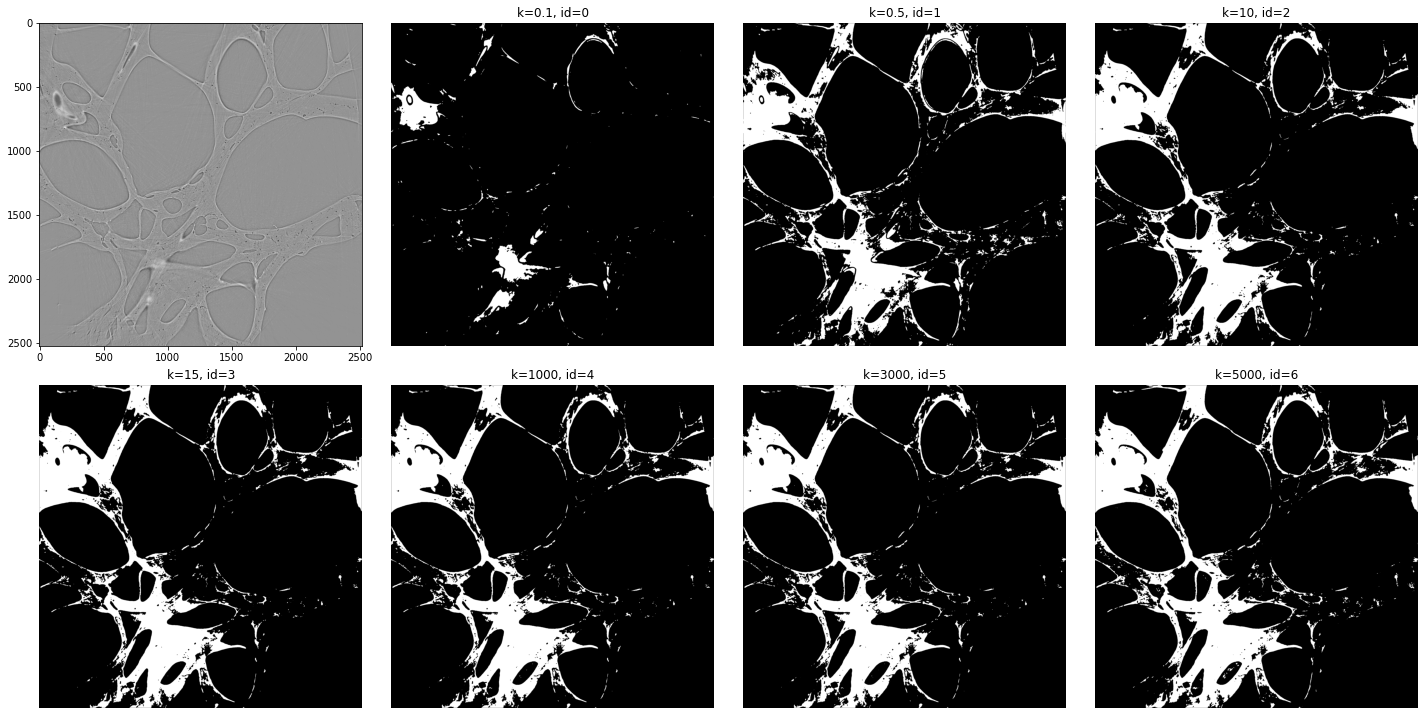

In [8]:

k_possible_values = [1/10, 1/2, 10, 15, 1000, 3000, 5000]
slice_num = 1090
k = k_possible_values[0]

img2d_gray = get_2d_slice(slice_num)
fig, axes = plt.subplots(2, 4, figsize=(20,10))

axes = axes.ravel()
axes[0].imshow(img2d_gray, cmap='gray')

for i, k in enumerate(k_possible_values):
    axes[i+1].imshow(pc.binarize_slice(img2d_gray, k=k, mu=25e-8), cmap='gray')
    axes[i+1].set_title(f"k={k}, id={i}")
    axes[i+1].axis("off")

plt.tight_layout()

In [13]:
data_fft = np.fft.fft2(img2d_gray)

def get_fft_section(slice_num):
    img2d_gray = get_2d_slice(slice_num)
    freq = np.fft.fftshift(np.abs(np.fft.fft2(img2d_gray)))
    return freq[freq.shape[0]//2]

def get_corr_section(slice_num, k):
    img2d_gray = get_2d_slice(slice_num)
    freq = np.fft.fftshift(np.fft.fftfreq(img2d_gray.shape[0]))
    fx, fy = np.meshgrid(freq, freq)
    f2 = np.sqrt(fx**2+fy**2)[freq.shape[0]//2]
    mu=25e-8
    return 1/np.sqrt(k * f2**2 + mu)


#plt.hist(f2[f2.shape[0]//2], bins = 200)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(get_f2_section(slice_num=1090), label='1090')
#ax.plot(get_corr_section(slice_num=1090, k=3000), label='corr 1090')
ax.plot(get_f2_section(slice_num=750), label='750')
#ax.plot(get_corr_section(slice_num=750, k=1), label='corr 750')
ax.legend()
ax.grid()

NameError: name 'get_f2_section' is not defined

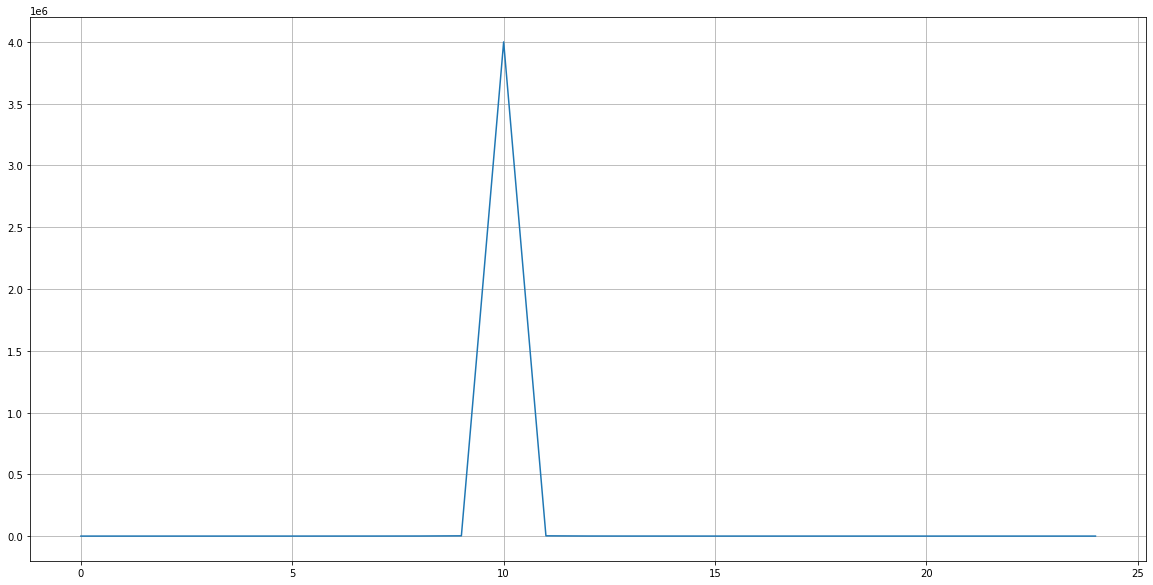

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(get_corr_section(slice_num=750, k=3000)[1250:1275], label='corr 750')
#ax.plot(get_corr_section(slice_num=750, k=500)[1250:1275], label='corr 750')
ax.grid()


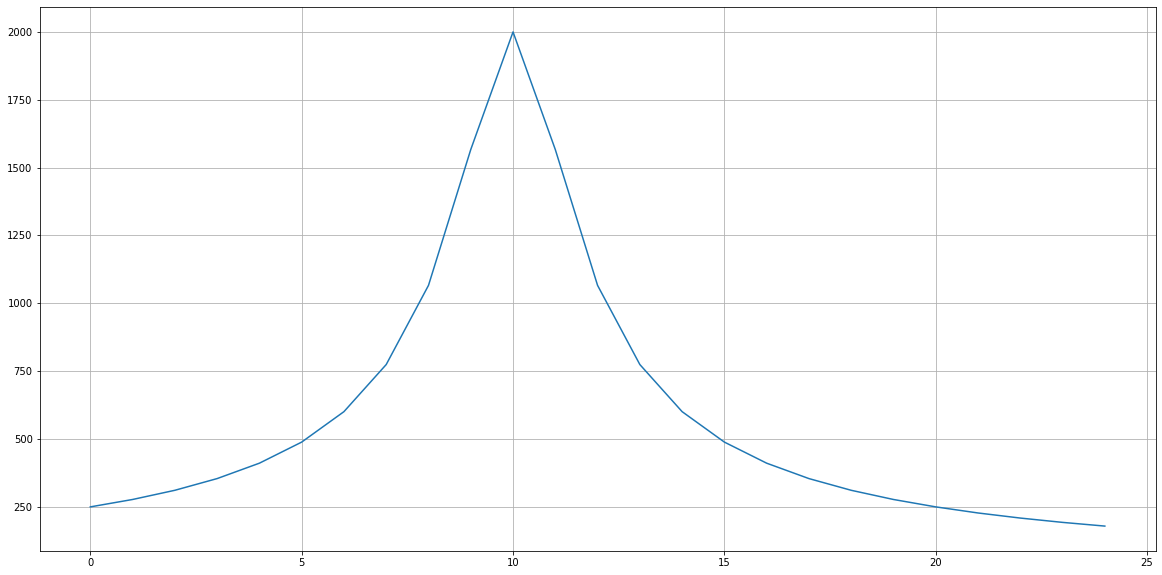

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(get_corr_section(slice_num=750, k=1)[1250:1275], label='corr 750')
ax.grid()


In [97]:

def interpolate_k_values(indexes_of_slices, k_values, max_number_of_slices):
    f = interp1d(indexes_of_slices, k_values, kind='nearest', fill_value="extrapolate")
    xnew = np.arange(0, max_number_of_slices, 1)
    print(xnew)
    return xnew, f(xnew)

In [102]:
x=[1,4,6,9]
y=[1,2,3,4]
interpolate_k_values(x, y,10)

[0 1 2 3 4 5 6 7 8 9]


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1., 1., 1., 2., 2., 2., 3., 3., 4., 4.]))